# High dimensional bilinear game on the simplex

Results on the following constrained bilinear game, where $\mathbf{x}_1, \mathbf{x}_2 \in \mathbb{R}^{500}$, and $\eta \in (0,1)$:

$ 
min_{\mathbf{x}_1} max_{\mathbf{x}_2} \quad \eta \cdot \mathbf{x}_1^\intercal + (1-\eta) \cdot \mathbf{x}_1^\intercal \mathbf{x}_2 - \eta \cdot \mathbf{x}_2^\intercal \mathbf{x}_2
$

$
\hspace{2em} \text{s.t.} \qquad \mathbf{x} \geq \mathbf{0}
$

$
\hspace{5em} \mathbf{e}^\intercal \mathbf{x}_1 = 1
$

$
\hspace{5em} \mathbf{e}^\intercal \mathbf{x}_2 = 1
$

In [ ]:
#@title install latex for plots description
! sudo apt install texlive-latex-extra
! sudo apt install dvipng
! sudo apt-get install texlive-full

In [1]:
#@title problem setup
import numpy as np
import scipy.optimize as opt
from scipy import linalg
import matplotlib.pyplot as plt
from cvxopt import matrix,solvers
solvers.options['show_progress'] = False

eps = .02
dim = 500  # dim(x1) == dim(x2) == dim
x_opt = np.ones((2*dim,1))/dim
_seed = 0


temp1 = np.concatenate((np.ones((1,dim)), np.zeros((1,dim))),axis=1)
temp2 = np.concatenate((np.zeros((1,dim)), np.ones((1,dim))),axis=1)
C = np.concatenate((temp1,temp2), axis=0)
d = np.ones((2,1))
temp = np.linalg.inv(np.dot(C, C.T))
temp = np.dot(C.T, temp)
dc = np.dot(temp, d)
Pc = np.identity(2*dim) - np.dot(temp,C)

G = matrix(-np.identity(2*dim), tc='d')
h = matrix(np.zeros(((2*dim,1))), tc='d')
AA = matrix(C, tc='d')
b = matrix(d, tc='d')

def f_y(y,c,mu): 
  """ Update y in Alg. ACVI. """
  return -mu * np.sum(np.log(y)) + beta/2 * np.sum((y-c)**2)

def proj(z):
  P = matrix(np.identity(2*dim), tc='d')
  q = matrix(-z, tc='d')
  res = solvers.qp(P, q, G, h, AA, b)
  return res['x']

np.random.seed(_seed)
init = np.random.rand(2*dim, 1)
init[:dim] = init[:dim] / np.sum(init[:dim])
init[dim:] = init[dim:] / np.sum(init[dim:])

print('Init {}'.format(init[:2]))

Init [[0.00221029]
 [0.00288036]]


## For fixed $\epsilon$ and varying rotation component $\eta$ ($x$-axis), compute number of iterations ($y$-axis) needed to be at most $\epsilon$ far away from the solution

In [ ]:
from numpy.core.arrayprint import format_float_scientific

eps = .02
gamma = .3  # step-size for EG, OGDA, LA
max_iters = 500
T, K = 10, 1
last_K = max_iters - (T-1) * K
n = (T-1) * K + last_K
num_acvi, num_gda, num_eg, num_la, num_ogda = [], [], [], [], []  
rot = np.linspace(.01, .99, 5)  #  rot = np.linspace(.01, .99, 30) 

for a in rot:
  A1 = np.concatenate((a*np.identity(dim), (1-a)*np.identity(dim)), axis=1)
  A2 = np.concatenate((-(1-a)*np.identity(dim), a*np.identity(dim)), axis=1)
  A = np.concatenate((A1, A2), axis=0)

  # ACVI ------------
  beta, mu, delta = .5, 1e-6, .5
  y, lmd = init, np.zeros(((2*dim,1)))
  finished, cnt = False, 0
  for t in range(0, T):
    mu *= delta
    flag = 1
    for k in range(0, K if t+1 < T else last_K):
      cnt += 1
      x = linalg.solve(np.identity(2*dim) + np.dot(Pc,A)/beta,
                       np.dot(Pc, y-lmd/beta) + dc)
      if np.linalg.norm(x-x_opt)/np.linalg.norm(x_opt) <= eps or \
         cnt == max_iters:
        finished = True
        num_acvi.append(cnt)
        break
      res = opt.minimize(lambda z: f_y(z,x+lmd/beta,mu), y, method='SLSQP')
      if not res.success:
        print('Failed to update y. t={}. k={}'.format(t, k))
        flag = 0
        break
      y = res.x.reshape(-1,1)
      lmd += beta*(x-y)
    if flag == 0 or finished:
      break

  # GDA ------------
  z = np.copy(init)
  for t in range(n):
    z = proj(z - gamma * np.dot(A,z))
    if np.linalg.norm(z-x_opt)/np.linalg.norm(x_opt) <= eps or t+1 >= max_iters:
      num_gda.append(t+1)
      break

  # EG ------------
  z = np.copy(init)
  for t in range(n):
    zz = proj(z-gamma*np.dot(A,z))
    z = proj(z-gamma*np.dot(A,zz))
    if np.linalg.norm(z-x_opt)/np.linalg.norm(x_opt) <= eps or \
       (t+1)*2 >= max_iters:
      num_eg.append(2*(t+1))
      break

  # OGDA ------------
  z0 = np.copy(init)
  z1 = np.copy(init)
  for t in range(n):
    z = proj(z1 - 2*gamma*np.dot(A,z1) + gamma*np.dot(A,z0))
    z0 = np.copy(z1)
    z1 = np.copy(z)
    if np.linalg.norm(z-x_opt) / np.linalg.norm(x_opt) <= eps or \
       t+1 >= max_iters:
      num_ogda.append(t+1)
      break

  # LA ------------
  z = np.copy(init)
  la_k, la_alpha = 5, 0.5
  for t in range(n):
    z_old = np.copy(z)
    for _ in range(la_k):
      #z = z - gamma * np.dot(A,z)
      z = proj( z - gamma * np.dot(A, z))
    z = proj(la_alpha * z_old + (1-la_alpha) * z)
    if np.linalg.norm(z - x_opt) / np.linalg.norm(x_opt) <= eps or \
       (t+1) * la_k >= max_iters:
      num_la.append(min(la_k*(t+1), max_iters))
      break

GDA:    [500, 66, 23, 14, 10]
EG:     [150, 64, 44, 36, 30]
OGDA:   [63, 32, 23, 17, 14]
LA-GDA: [95, 60, 45, 40, 35]
ACVI:   [18, 9, 6, 6, 5]


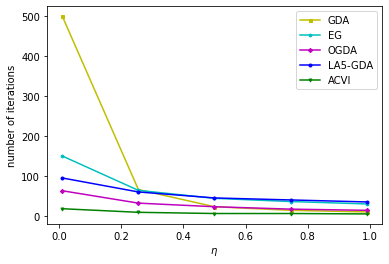

In [ ]:
ms = 3
print('GDA:    {}'.format(num_gda))
print('EG:     {}'.format(num_eg))
print('OGDA:   {}'.format(num_ogda))
print('LA-GDA: {}'.format(num_la))
print('ACVI:   {}'.format(num_acvi))

plt.plot(rot, num_gda, 'ys-', label='GDA', markersize=ms)
plt.plot(rot, num_eg, 'ch-', label='EG', markersize=ms)
plt.plot(rot, num_ogda, 'mD-',label='OGDA', markersize=ms)
plt.plot(rot, num_la, 'bo-', label='LA{}-GDA'.format(la_k), markersize=ms)
plt.plot(rot, num_acvi, 'gv-', label='ACVI', markersize=ms)
plt.xlabel(r'$\eta$')
plt.ylabel('number of iterations')
plt.legend(loc="upper right")
plt.savefig('acvi_hd_bilinear_eta.pdf', bbox_inches='tight')
plt.show()

## For fixed rotation $\eta=.05$ and varying CPU time ($x$-axis), compute relative error ($y$-axis)

In [ ]:
import time

aa = .05
max_iters = 5000
T, K = 10, 1
last_K = max_iters - (T-1) * K
n = (T-1) * K + last_K
la_k, la_alpha = 5, .5  # hyperparameters for LA-GDA 
gamma = .1  # step-size for GDA, EG, OGDA, LA-GDA
A1 = np.concatenate((aa*np.identity(dim), (1-aa)*np.identity(dim)), axis=1)
A2 = np.concatenate((-(1-aa)*np.identity(dim), aa*np.identity(dim)), axis=1)
A = np.concatenate((A1,A2), axis=0)

# tm = [60, 90, 120, 150, 180, 210, 240, 270]
tm = [60, 180, 270]
eps_acvi, eps_gda, eps_eg, eps_ogda, eps_lak = [], [], [], [], []

for dt in tm:
  # ACVI ------------
  t0 = time.time()
  timesup = False
  beta, mu, delta = .5, 1e-7, .5
  y, lmd = init, np.zeros(((2*dim,1)))
  for t in range(T):
    mu *= delta
    flag = 1
    for k in range(K if t+1<T else last_K):
      x = linalg.solve(np.identity(2*dim)+np.dot(Pc,A)/beta,np.dot(Pc,y-lmd/beta)+dc)
      res = opt.minimize(lambda z: f_y(z,x+lmd/beta,mu), y, method='SLSQP', jac=None)
      if not res.success:
        print('Failed to update y. t={}. k={}'.format(t,k))
        flag = 0
        break
      y = res.x.reshape(-1,1)
      lmd += beta*(x-y)
      if time.time()-t0 >= dt:
        eps_acvi.append(np.linalg.norm(x-x_opt)/np.linalg.norm(x_opt))
        timesup = True
        break
    if flag == 0 or timesup:
      break
  

  # GDA ------------
  z = np.copy(init)
  t0 = time.time()
  for t in range(n):
    z = proj(z - gamma*np.dot(A, z))
    if time.time()-t0 >= dt:
      # Relative error
      eps_gda.append(np.linalg.norm(z-x_opt)/np.linalg.norm(x_opt))
      break

  # EG ------------
  z = np.copy(init)
  t0 = time.time()
  for t in range(n):
    zz = proj(z - gamma*np.dot(A, z))
    z = proj(z - gamma*np.dot(A, zz))
    if time.time()-t0 >= dt:
      eps_eg.append(np.linalg.norm(z-x_opt) / np.linalg.norm(x_opt))
      break

  # OGDA ------------
  z0 = np.copy(init)
  z1 = np.copy(init)
  t0 = time.time()
  for t in range(n):
    z = proj(z1 - 2*gamma*np.dot(A,z1) + gamma*np.dot(A,z0))
    z0 = np.copy(z1) 
    z1 = np.copy(z0) 
    if time.time()- t0 >= dt:
      eps_ogda.append(np.linalg.norm(z-x_opt) / np.linalg.norm(x_opt))
      break

  # LA5-GDA ------------
  z = np.copy(init)
  t0 = time.time()
  for t in range(n):
    z_old = z
    for _ in range(la_k):
      z = proj(z - gamma*np.dot(A,z))
    z = proj(la_alpha * z_old + (1-la_alpha) * z)
    if time.time() - t0 >= dt:
      eps_lak.append(np.linalg.norm(z-x_opt)/np.linalg.norm(x_opt))
      break

CPU-time: [60, 180, 270]
GDA:      [0.5145986619628568, 0.43888856687104627, 0.3961038745965842]
EG:       [0.3012852130692706, 0.08117955504120694, 0.03117351039238496]
OGDA:     [0.5848684785035604, 0.5848684785035604, 0.5848684785035604]
LA5-GDA:  [0.28825187323310963, 0.07110590692614277, 0.026617190845794735]
ACVI:     [0.02904948188322766, 0.00016789817370326595, 4.061120650482063e-06]


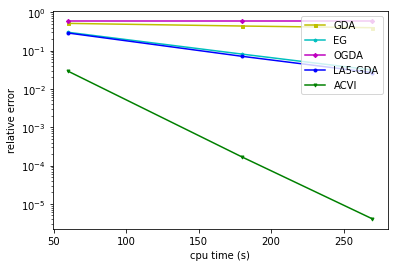

In [24]:
ms = 3
print('CPU-time: {}'.format(tm))
print('GDA:      {}'.format(eps_gda))
print('EG:       {}'.format(eps_eg))
print('OGDA:     {}'.format(eps_ogda))
print('LA{}-GDA:  {}'.format(la_k, eps_lak))
print('ACVI:     {}'.format(eps_acvi))

plt.plot(tm,eps_gda,'ys-', label='GDA', markersize=ms)
plt.plot(tm,eps_eg,'ch-', label='EG', markersize=ms)
plt.plot(tm,eps_ogda,'mD-', label='OGDA', markersize=ms)
plt.plot(tm,eps_lak,'bo-', label='LA{}-GDA'.format(la_k), markersize=ms)
plt.plot(tm,eps_acvi,'gv-', label='ACVI', markersize=ms) 
plt.legend(loc='upper right')
plt.xlabel('cpu time (s)')
plt.ylabel('relative error')
plt.yscale('log')
plt.savefig('acvi_hd_bilinear_relErr_vs_time.pdf', bbox_inches='tight')
plt.show()

## For fixed rotation $\eta=.05$ and varying relative error ($x$-axis), compute CPU time ($y$-axis)

In [25]:
import time

aa = .05
max_cpu_time = 1500  # in sec
max_iters = 3000
T, K = 10, 1
last_K = max_iters - (T-1) * K
n = (T-1) * K + last_K
la_k, la_alpha = 5, .5  # hyperparameters for LA-GDA 
gamma = .1  # Step-size for GDA, EG, OGDA, LA-GDA
A1 = np.concatenate((aa*np.identity(dim),(1-aa)*np.identity(dim)),axis=1)
A2 = np.concatenate((-(1-aa)*np.identity(dim),aa*np.identity(dim)),axis=1)
A = np.concatenate((A1,A2),axis=0)
t_acvi, t_gda, t_eg, t_ogda, t_lak = [], [], [], [], []
eps = [.5, .1, .05, .01, .001, .0005]

for de in eps:
  # ACVI ------------
  beta, mu, delta = .5, 1e-6, .5
  y, lmd = init,np.zeros(((2*dim,1)))
  t0 = time.time()
  for t in range(T):
    mu *= delta
    flag = 1
    for k in range(K if t+1 < T else last_K):
      x = linalg.solve(np.identity(2*dim)+np.dot(Pc,A)/beta,np.dot(Pc,y-lmd/beta)+dc)
      if np.linalg.norm(x-x_opt)/np.linalg.norm(x_opt) <= de or \
         time.time()-t0 >= max_cpu_time:
        flag = 0
        t_acvi.append(time.time()-t0)
        break
      res = opt.minimize(lambda z: f_y(z,x+lmd/beta,mu), y, method='SLSQP', jac=None)
      if not res.success:
        print('Failed to update y. t={}. k={}'.format(t,k))
        flag = 0
        break
      y = res.x.reshape(-1,1)
      lmd += beta*(x-y)
    if flag == 0:
      break

  # GDA ------------
  z = np.copy(init)
  t0 = time.time()
  for t in range(n):
    z = proj(z-gamma*np.dot(A,z))
    if np.linalg.norm(z-x_opt) / np.linalg.norm(x_opt) <= de or \
        time.time()-t0 >= max_cpu_time:
      t_gda.append(time.time()-t0)
      break

  # EG ------------
  z = np.copy(init)
  t0 = time.time()
  for t in range(n):
    zz = proj(z-gamma*np.dot(A,z))
    z = proj(z-gamma*np.dot(A,zz))
    if np.linalg.norm(z-x_opt)/np.linalg.norm(x_opt) <= de or \
        time.time()-t0 >= max_cpu_time:
      t_eg.append(time.time()-t0)
      break
  # OGDA ------------
  z0 = np.copy(init)
  z1 = np.copy(init)
  t0 = time.time()
  for t in range(n):
    z = proj(z1 - 2*gamma*np.dot(A,z1) + gamma*np.dot(A,z0))
    z0 = np.copy(z1)
    z1 = np.copy(z)
    if np.linalg.norm(z-x_opt)/np.linalg.norm(x_opt) <= de or \
        time.time()-t0 >= max_cpu_time:
      t_ogda.append(time.time()-t0)
      break

  # LAK-GDA ------------
  la_k, la_alpha = 5, .5 
  z = np.copy(init)
  t0 = time.time()
  for t in range(n):
    z_old = z
    for i in range(la_k):
      z = proj(z-gamma*np.dot(A, z))
    z = proj(la_alpha*z_old + (1-la_alpha)*z)
    if np.linalg.norm(z-x_opt) / np.linalg.norm(x_opt) <= de or \
        time.time()-t0 >= max_cpu_time:
      t_lak.append(time.time()-t0)
      break

GDA:      [78.64775919914246]
EG:       [15.134716033935547, 161.77575206756592, 226.96552443504333, 376.7856979370117, 587.2638783454895, 656.7127356529236]
OGDA:     [7.774897813796997, 84.55064845085144, 116.01626467704773, 194.55628848075867, 293.76169443130493, 329.068234205246]
LA5-GDA: [14.562126159667969, 157.92764544487, 218.11382746696472, 357.96415185928345, 564.7706151008606, 627.1676275730133]
ACVI:     [0.13395404815673828, 33.48216962814331, 47.89238142967224, 78.29657125473022, 125.12867450714111, 140.62643718719482]


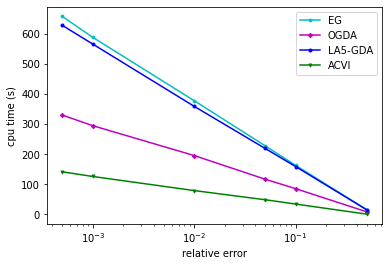

In [31]:
ms = 3
print('GDA:      {}'.format(t_gda))
print('EG:       {}'.format(t_eg))
print('OGDA:     {}'.format(t_ogda))
print('LA{}-GDA: {}'.format(la_k, t_lak))
print('ACVI:     {}'.format(t_acvi))

# plt.plot(eps, t_gda, 'ys-', label='GDA', markersize=ms) <- GDA too slow
plt.plot(eps, t_eg, 'ch-', label='EG', markersize=ms)
plt.plot(eps, t_ogda, 'mD-', label='OGDA', markersize=ms)
plt.plot(eps, t_lak, 'bo-', label='LA{}-GDA'.format(la_k), markersize=ms)
plt.plot(eps, t_acvi, 'gv-', label='ACVI', markersize=ms)
plt.xscale('log')
plt.xlabel('relative error')
plt.ylabel('cpu time (s)')
plt.legend(loc='upper right')
plt.savefig('acvi_hd_bilinear_time_vs_relErr.pdf', bbox_inches='tight')
plt.show()